In [1]:
import jax.numpy as jnp
from jax import grad, vmap, jit, random, lax

import kagglehub
import matplotlib.pyplot as plt
import numpy as np

# path = kagglehub.dataset_download("hojjatk/mnist-dataset")  # download mnist
path = '/home/tibless/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1'
key = random.PRNGKey(239)  # 239; 412
print(f'mnsit at: {path}')

mnsit at: /home/tibless/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


In [2]:
# load mnist

import os
import struct
import numpy as np

def read_idx(filename):
    """
    Read MNIST data from file using idx format.

    Return
    ------
    np.ndarray
    """
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

TRAIN = 60000
TEST  = 10000
train_images = read_idx(os.path.join(path, 'train-images.idx3-ubyte'))[:TRAIN]
train_labels = read_idx(os.path.join(path, 'train-labels.idx1-ubyte'))[:TRAIN]
test_images = read_idx(os.path.join(path, 't10k-images.idx3-ubyte'))[:TEST]
test_labels = read_idx(os.path.join(path, 't10k-labels.idx1-ubyte'))[:TEST]

shuffle_kernel = np.random.permutation(np.arange(TRAIN))
train_images = train_images[shuffle_kernel]
train_labels = train_labels[shuffle_kernel]

print("训练图像数据大小: ", train_images.shape)
print("训练标签数据大小: ", train_labels.shape)
print("测试图像数据大小: ", test_images.shape)
print("测试标签数据大小: ", test_labels.shape)

训练图像数据大小:  (60000, 28, 28)
训练标签数据大小:  (60000,)
测试图像数据大小:  (10000, 28, 28)
测试标签数据大小:  (10000,)


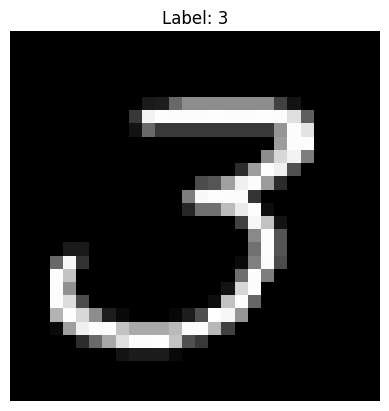

In [3]:
ix = 4
plt.imshow(train_images[ix], cmap='gray')
plt.title(f"Label: {train_labels[ix]}")
plt.axis('off')  # 不显示坐标轴
plt.show()

In [4]:
X_train = jnp.array(train_images.reshape(train_images.shape[0], 1, 28, 28)) / 255.
y_train = jnp.array(train_labels)
X_test = jnp.array(test_images.reshape(test_images.shape[0], 1, 28, 28)) / 255.
y_test = jnp.array(test_labels)

def one_hot(y: jnp.ndarray, num_class: int):
    res = jnp.zeros((y.shape[0], num_class))
    res = res.at[jnp.arange(y.shape[0]), y].set(1)
    return res

y_train_one_hot = one_hot(y_train, 10)
y_test_one_hot = one_hot(y_test, 10)

In [5]:
import jax.numpy as jnp

from plugins.minitorch.initer import Initer
from plugins.minitorch.optimizer import Adam
from plugins.minitorch.nn import Conv, Dense
from plugins.minitorch.utils import softmax
from plugins.minitorch.loss import CrossEntropyLoss

class LeNet:
    def __init__(self, lr=0.01, batch_size=32):
        self.config = {
            'conv2d:0': Conv.get_conv2d(1, 6, (5, 5), 2),
            'max_pooling:0': Conv.get_max_pool2d((2, 2)),
            'conv2d:1': Conv.get_conv2d(6, 16, (5, 5), 0),
            'max_pooling:1': Conv.get_max_pool2d((2, 2)),
            'fc:0': Dense.get_linear(400, 120),
            'fc:1': Dense.get_linear(120, 84),
            'fc:2': Dense.get_linear(84, 10),
        }

        initer = Initer(self.config, key)
        self.optr = Adam(initer(), lr=lr, batch_size=batch_size)
        self.losser = CrossEntropyLoss(self.forward)

    def forward(self, x: jnp.ndarray, params, train=True):
        res = Conv._conv2d(x, params['conv2d:0']['w'], params['conv2d:0']['b'], padding=self.config['conv2d:0']['padding'])
        res = jnp.maximum(0, res)
        res = Conv._max_pooling2d(res, pool_size=self.config['max_pooling:0']['pool_size'])
        
        res = Conv._conv2d(res, params['conv2d:1']['w'], params['conv2d:1']['b'], padding=self.config['conv2d:1']['padding'])
        res = jnp.maximum(0, res)
        res = Conv._max_pooling2d(res, pool_size=self.config['max_pooling:1']['pool_size'])

        res = res.reshape(res.shape[0], -1)

        res = res @ params['fc:0']['w'] + params['fc:0']['b']
        res = jnp.maximum(0, res)
        
        res = res @ params['fc:1']['w'] + params['fc:1']['b']
        res = jnp.maximum(0, res)
        
        res = res @ params['fc:2']['w'] + params['fc:2']['b']

        return softmax(res)

    def fit(self, x_train, y_train_proba, x_test, y_test_proba, epoches=100): 
        @jit
        def _acc(y_true_proba, y_pred_proba):
            y_true = jnp.argmax(y_true_proba, axis=1)
            y_pred = jnp.argmax(y_pred_proba, axis=1)
            return jnp.mean(y_true == y_pred)

        _loss = self.losser.get_loss(train=True)
        _loss = jit(_loss)
        self.optr.open(_loss, x_train, y_train_proba)
        
        _tloss = self.losser.get_embed_loss(x_test, y_test_proba, train=False)
        _tloss = jit(_tloss)
        

        acc, loss, tacc, tloss = [], [], [], []  # train acc, train loss, test acc, test loss

        for cnt in range(epoches):
            loss.append(_loss(self.optr.get_params(), x_train, y_train_proba))
            tloss.append(_tloss(self.optr.get_params()))

            self.optr.update()
            
            acc.append(_acc(y_train_proba, self.forward(x_train, self.optr.get_params())))
            tacc.append(_acc(y_test_proba, self.forward(x_test, self.optr.get_params())))
            if (cnt + 1) % 2 == 0:
                print(f'>> epoch: {cnt + 1}, train acc: {acc[-1]}, test acc: {tacc[-1]}')

        return acc, loss, tacc, tloss

In [6]:
epochs = 10
batch_size = 512
learning_rate = 0.01

model = LeNet(lr=learning_rate, batch_size=batch_size)
acc, loss, tacc, tloss = model.fit(
    x_train=X_train, 
    y_train_proba=y_train_one_hot,
    x_test=X_test,
    y_test_proba=y_test_one_hot,
    epoches=epochs)

[*] oprimizer opened with 117 batches with batch size 512.
>> epoch: 10, train acc: 0.9876333475112915, test acc: 0.98089998960495


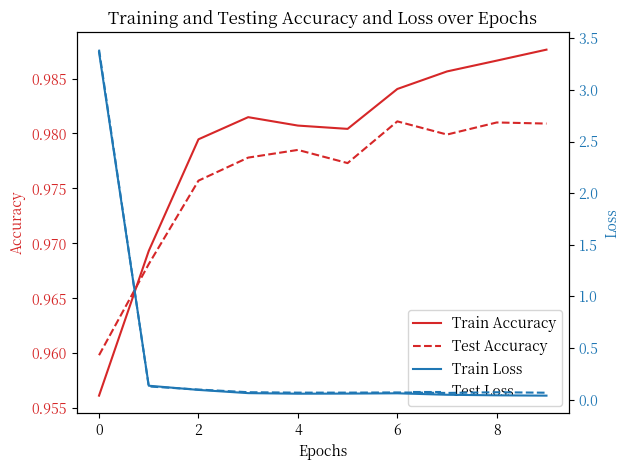

final train, test acc : 0.9876333475112915, 0.98089998960495
final train, test loss: 0.040280524641275406, 0.06864224374294281


In [7]:
fig, ax1 = plt.subplots()

plt.rcParams['font.family'] = 'Noto Serif SC'
plt.rcParams['font.sans-serif'] = ['Noto Serif SC']

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(range(epochs), acc, color=color, label='Train Accuracy', linestyle='-')
ax1.plot(range(epochs), tacc, color=color, label='Test Accuracy', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)  
ax2.plot(range(epochs), loss, color=color, label='Train Loss', linestyle='-')
ax2.plot(range(epochs), tloss, color=color, label='Test Loss', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='lower right')

plt.title('Training and Testing Accuracy and Loss over Epochs')
fig.tight_layout()
# plt.savefig('./assets/LeNet.svg', format='svg')
plt.show()

print(f'final train, test acc : {acc[-1]}, {tacc[-1]}')
print(f'final train, test loss: {loss[-1]}, {tloss[-1]}')